In [1]:
import json
import os
import glob
import matplotlib.pyplot as plt
import shutil

In [23]:
baboon_images_root = '/home/golden/Dropbox/tracking-projects/baboons/frames_for_annotation'
new_baboon_images_root = '/home/golden/kenya_drones/night_baboons/annotations/jan-26-2020-annotations/raw-annotations/frames_matching_annotations'
annotations_root = '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations'
new_annotations_root = '/home/golden/kenya_drones/night_baboons/annotations/jan-26-2020-annotations/raw-annotations/annotations/json'
output_folder = '/home/golden/kenya_drones/night_baboons/annotations/jan-26-2020-annotations/coco-annotations' 
coco_annotation_file = os.path.join(output_folder, 'baboon_coco_annotations.json')
output_image_folder = os.path.join(output_folder, 'images')
os.makedirs(output_image_folder, exist_ok=True)
baboon_folders = glob.glob(os.path.join(baboon_images_root, '*'))
baboon_folders = glob.glob(os.path.join(new_baboon_images_root, '*'))
# print(*baboon_folders, sep='\n')

In [3]:
old_image_files = glob.glob(os.path.join(baboon_images_root, '*', '*.tiff'))
new_image_files = glob.glob(os.path.join(new_baboon_images_root, '*', '*.tiff'))
missing = 0 
for file in old_image_files:
    name = os.path.basename(file)
    if not name in new_image_files:
        missing += 1
        
print(missing)
image_files = old_image_files + new_image_files

172


In [4]:
image_names = [os.path.basename(f) for f in image_files]
short_names = ['_'.join(name.split('_')[1:]) for name in image_names]




In [5]:
print(len(image_files), len(list(set(image_files))))
print(len(short_names), len(list(set(short_names))))

1122 1122
1122 1122


In [6]:
loopy_annotations = glob.glob(annotations_root+'/*')
loopy_annotations

['/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190807_annotation_1389_34442_data.json',
 '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190803_annotation_1348_1001051_data.json',
 '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190803_annotation_1347_1952001_data.json',
 '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190803_annotation_1385_10151_data.json',
 '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190731_annotation_1369_161_data.json',
 '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190801_annotation_1324_01001_data.json',
 '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190806_annotation_1359_53581_data.json',
 '/home/golden/Dropbox/tracking-projects/baboons/loopy_json_annotations/video_1_20190803_annotation_1346_4101_data.json',
 '/home/golden/

In [6]:
bad_annotation_count = 0
bad_folders = []
last_bad_image_ids = []

# one id for every image
image_id = 1

file_id_dict = {}
categories = {}
# one id for every category
category_id = 1

# one id for every annotation
annotation_id = 1

annotations_raw = {}

annotations_raw ['info'] = []
annotations_raw ['info'].append({
    'description': 'Raw COCO style baboon annotations',
    'url': '',
    'version': '1.0',
    'year': 2021,
    'contributor': 'Carter Loftus Ben Koger',
    'date_created': '2021/01/26'    
})

annotations_raw ['licenses'] = []
annotations_raw ['licenses'].append({
    'url': '',
    'id': 0,
    'name': '',  
})

annotations_raw['images'] = []

annotations_raw['annotations'] = []

annotations_raw['categories'] = []


for folder_num, folder in enumerate(baboon_folders[:]):
    
    if folder_num % 10 == 0:
        print(f'{folder_num} / {len(baboon_folders)} done. {bad_annotation_count} bad annotations.')
    
    
    loopy_json_file = os.path.join(annotations_root, os.path.basename(folder)+'.json')
    if not os.path.exists(loopy_json_file):
        loopy_json_file = os.path.join(new_annotations_root, os.path.basename(folder)+'.json')
    if os.path.exists(loopy_json_file):
        image_files = sorted(glob.glob(os.path.join(folder, '*.tiff')))
        for image_file in image_files:
            if os.path.basename(image_file) == '038_20190807_161442000000.tiff':
                file_id_dict[int(os.path.basename(image_file).split('_')[0])] = 'skip'
                continue
                
            im = plt.imread(image_file)
            shutil.copy(image_file, output_image_folder)
            
            file_id_dict[int(os.path.basename(image_file).split('_')[0])] = image_id
            annotations_raw['images'].append({
                'license': 0,
                'file_name': os.path.basename(image_file),
                'coco_url': '',
                'height': im.shape[0],
                'width': im.shape[1],
                'date_captured': '',
                'flickr_url': '',
                'id': image_id
            })
            image_id += 1
        
        with open(loopy_json_file) as json_file:
            loopy_annotations = json.load(json_file)
        
        for annotation in loopy_annotations:
            
            if not annotation['frame_count']:
                annotation['frame_count'] = annotation['frame_number']
            if annotation['frame_count'] is None:
                bad_annotation_count += 1
                bad_folders.append(folder)
                last_bad_image_ids.append({'ff': image_id-len(image_files), 'lf': image_id})
                continue
            if file_id_dict[annotation['frame_count']] == 'skip':
                print('skipping frame count {}'.format(annotation['frame_count']))
                continue
            
            segmentation = [annotation['x0'], annotation['y0'],
                            annotation['x1'], annotation['y1'],
                            annotation['x2'], annotation['y2'],
                            annotation['x3'], annotation['y3'],
                           ]
            
            width = annotation['x1'] - annotation['x0']
            height = annotation['y2'] - annotation['y0']
            
            bbox = [annotation['x0'], annotation['y0'],
                    width, height
                    ]
            
            if not annotation['class'] in categories.keys():
                categories[annotation['class']] = category_id
                category_id += 1
            
            annotations_raw['annotations'].append({
                'segmentation': [segmentation],
                'area': width*height,
                'iscrowd': 0,
                'image_id': file_id_dict[int(annotation['frame_count'])],
                'bbox': bbox,
                'category_id': categories[annotation['class']],
                'id': annotation_id
            })  

            annotation_id += 1

for category, category_id in categories.items():
    annotations_raw['categories'].append({
        'supercategory': 'baboon',
        'id': category_id,
        'name': category

    })   
    
print('processed {} annotations in {} images'.format(annotation_id, image_id))



with open(coco_annotation_file, 'w') as outfile:
    json.dump(annotations_raw, outfile, indent=4)

0 / 107 done. 0 bad annotations.
10 / 107 done. 0 bad annotations.
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 38
skipping frame count 

In [6]:
# bad_folders_set = []
# last_bad_image_ids

In [10]:
len(last_bad_image_ids)

50

In [11]:
added = []
bad_ids_set = []
for d in last_bad_image_ids:
    if d['ff'] not in added:
        bad_ids_set.append(d)
        added.append(d['ff'])
print(len(bad_ids_set))

2


In [48]:
for folder_num, folder in enumerate(baboon_folders[:]):
    
#     if folder_num % 10 == 0:
#         print(f'{folder_num} / {len(baboon_folders)} done. {bad_annotation_count} bad annotations.')
    
    
    loopy_json_file = os.path.join(annotations_root, os.path.basename(folder)+'.json')
    if not os.path.exists(loopy_json_file):
        loopy_json_file = os.path.join(new_annotations_root, os.path.basename(folder)+'.json')
    if os.path.exists(loopy_json_file):
#         image_files = sorted(glob.glob(os.path.join(folder, '*.tiff')))
#         for image_file in image_files:
#             if os.path.basename(image_file) == '038_20190807_161442000000.tiff':
#                 file_id_dict[int(os.path.basename(image_file).split('_')[0])] = 'skip'
#                 print(image_file)
#                 continue
                
          
        num_none = 0
        with open(loopy_json_file) as json_file:
            loopy_annotations = json.load(json_file)

        out = False
        for annotation in loopy_annotations:

            if not annotation['frame_count']:
                annotation['frame_count'] = annotation['frame_number']
            if annotation['frame_count'] is None:
                num_none += 1
                
        if out:
            break
        if num_none != 0:   
#             print('num none', num_none)
            print(os.path.basename(loopy_json_file), f'- missing frame info for {num_none} annotations.')
    else:
        print('doesn\'t exist', os.path.basename(loopy_json_file))

video_20190812_155602640000_annotation_2037_0293_data.json - missing frame info for 39 annotations.
video_1_20190809_153148600000_annotation_1852_091_data.json - missing frame info for 11 annotations.
video_1_20190811_213117600000_annotation_1965_091_data.json - missing frame info for 36 annotations.
video_1_20190809_143058600000_annotation_1851_091_data.json - missing frame info for 1 annotations.
video_1_20190808_153811600000_annotation_1682_091_data.json - missing frame info for 22 annotations.
video_1_20190811_181849200000_annotation_1963_091_data.json - missing frame info for 35 annotations.
video_1_20190811_195503400000_annotation_1976_091_data.json - missing frame info for 37 annotations.
video_1_20190808_220228200000_annotation_1680_091_data.json - missing frame info for 31 annotations.
video_1_20190808_174617200000_annotation_1681_091_data.json - missing frame info for 33 annotations.
video_1_20190808_195422600000_annotation_1679_091_data.json - missing frame info for 34 annot

In [39]:
i = [d['frame_count'] for d in loopy_annotations if d['frame_count'] is None]
len(i)

1

In [38]:
i[:10]

[None, 3, 6, 9, 12, 15, 18, 21, 24, 27]

In [20]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
import cv2
import random

In [8]:
register_coco_instances("baboons", {}, coco_annotation_file, output_image_folder)

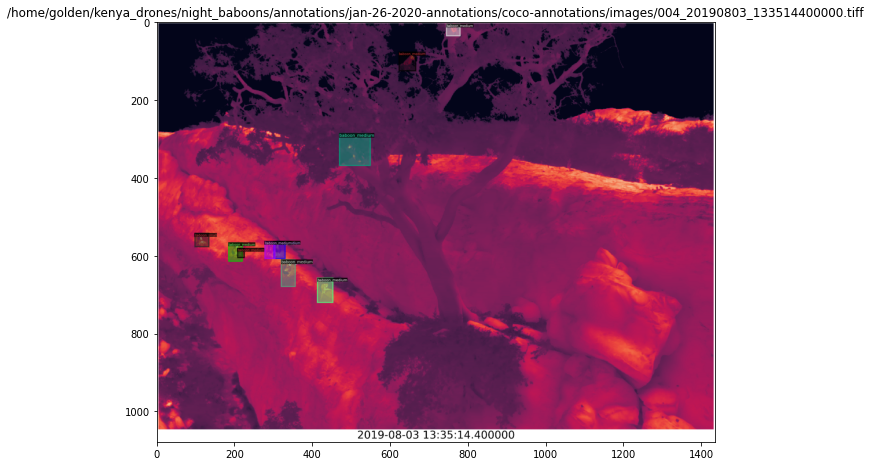

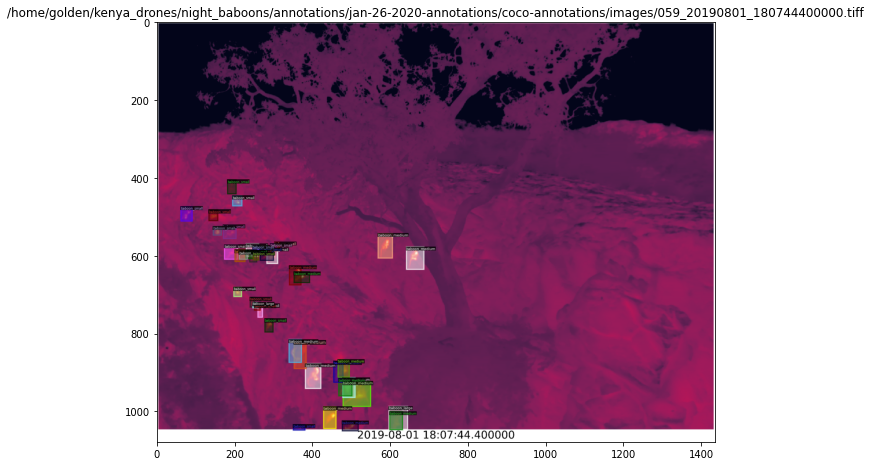

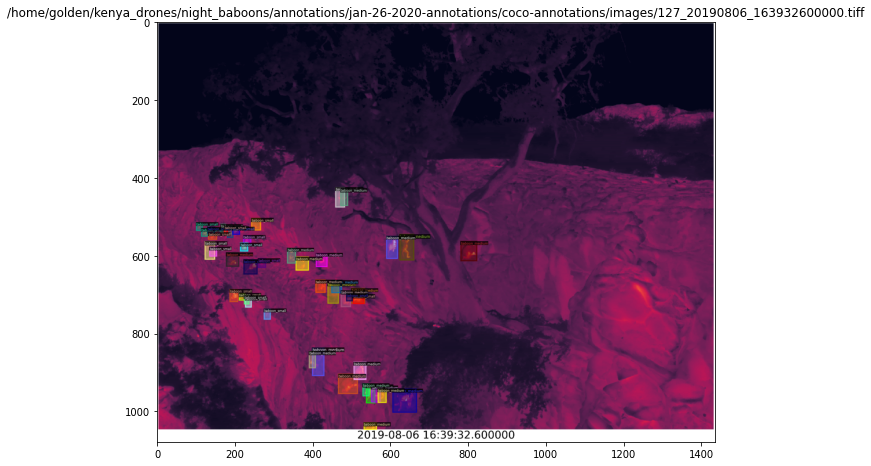

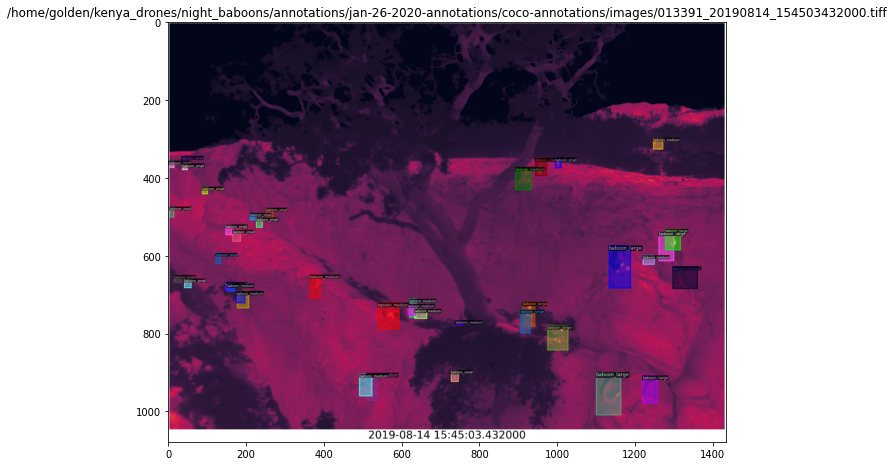

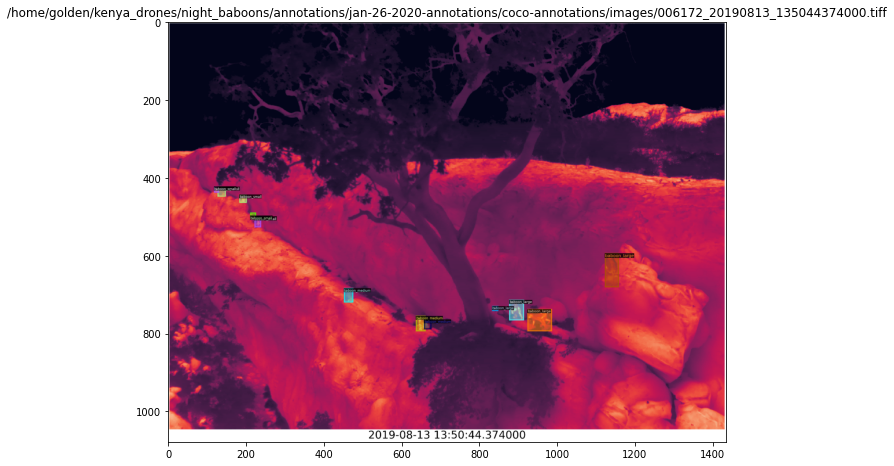

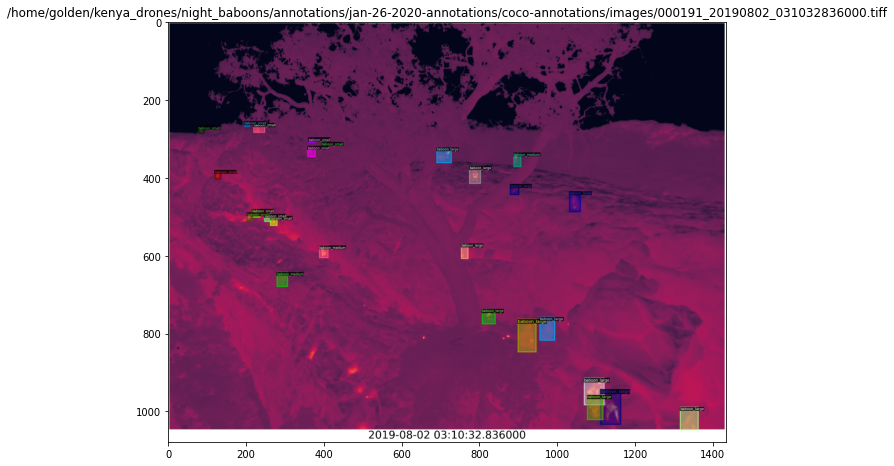

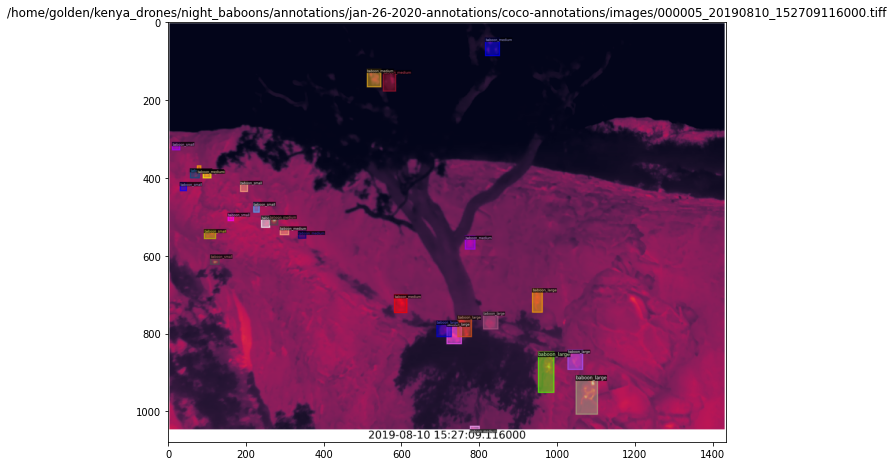

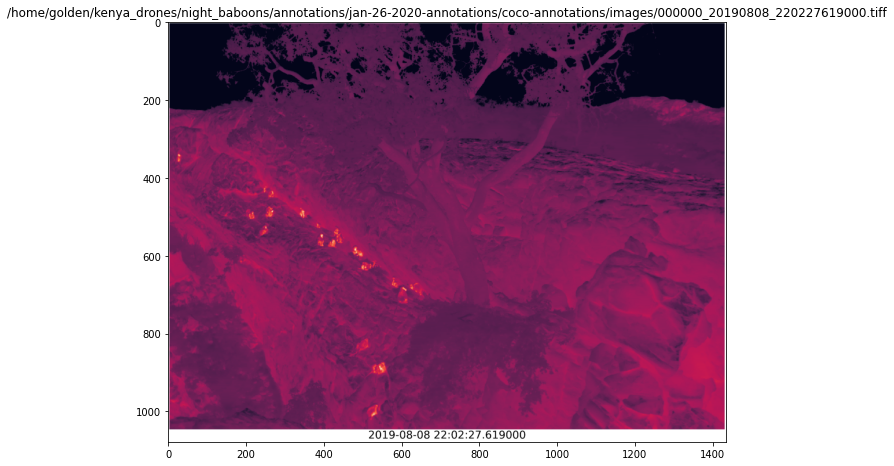

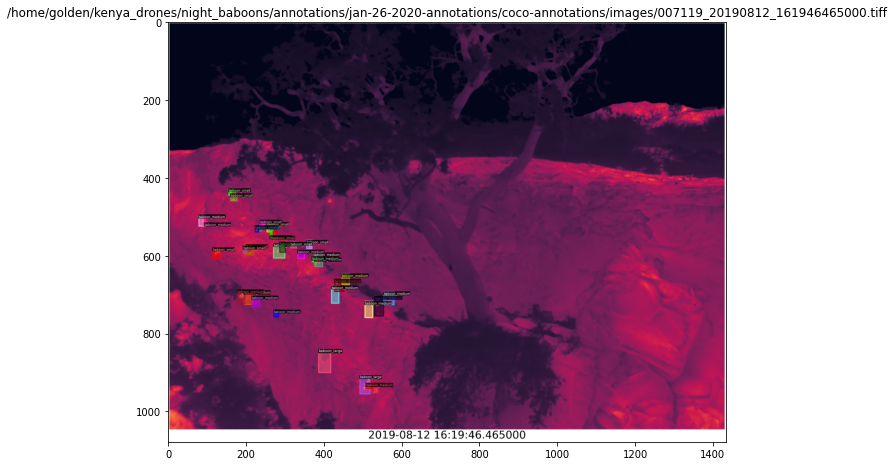

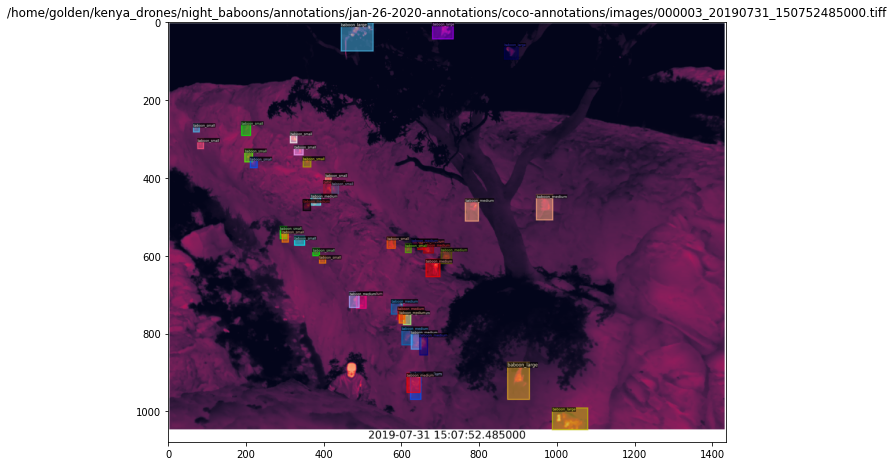

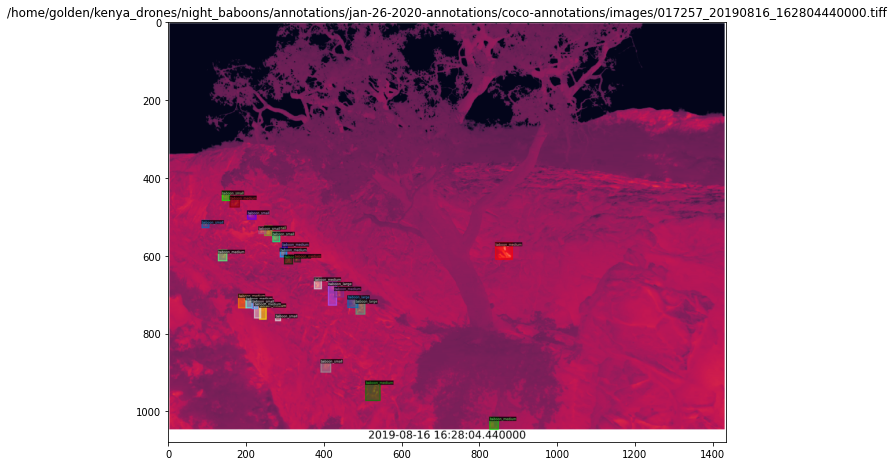

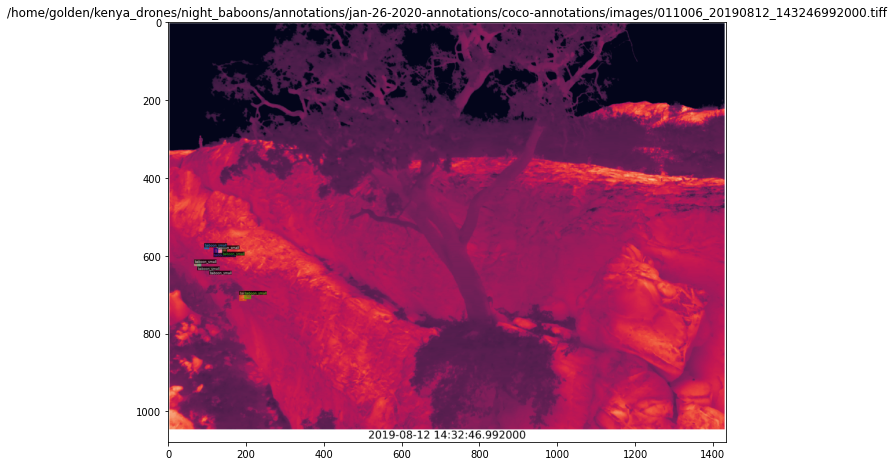

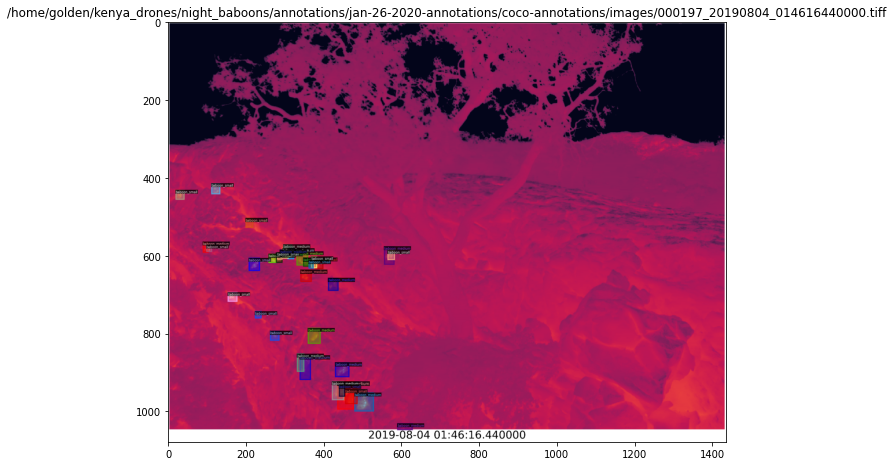

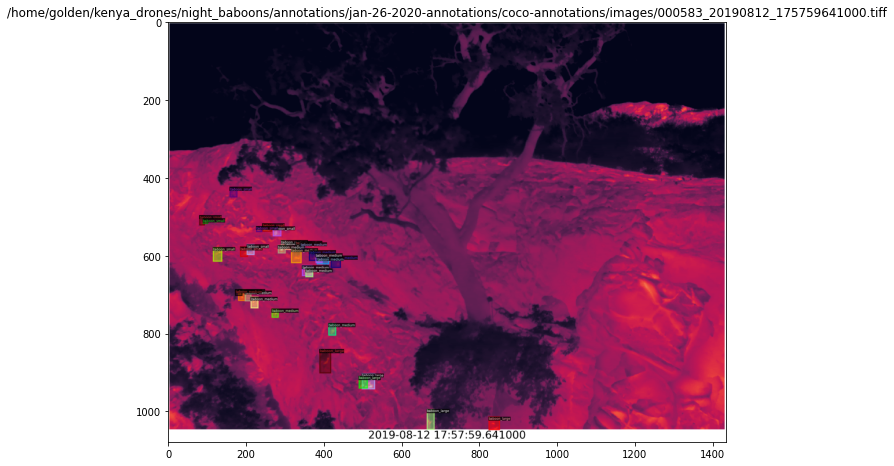

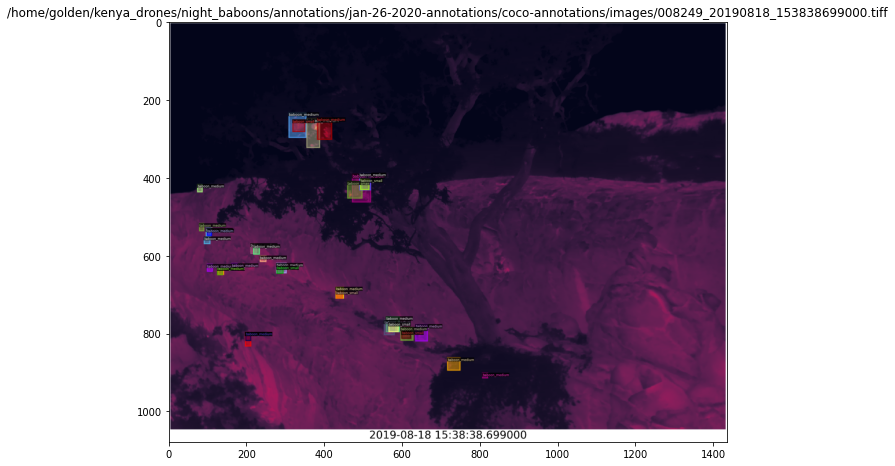

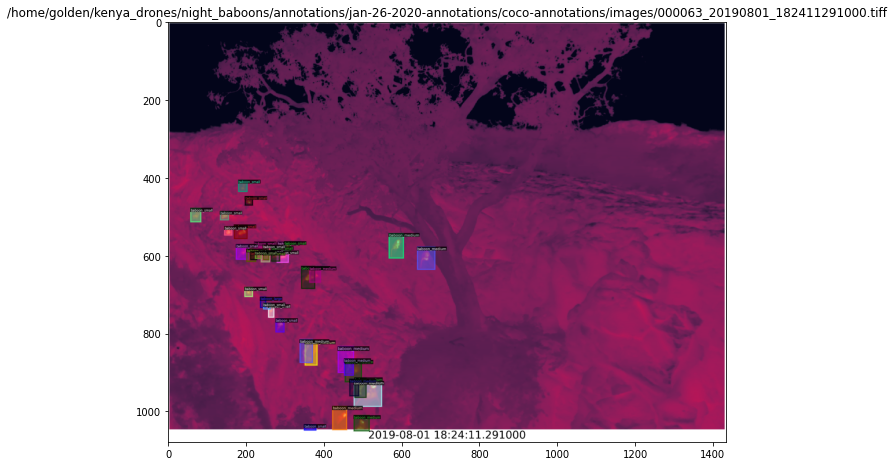

In [13]:
dataset_dicts = DatasetCatalog.get("baboons")
metadata = MetadataCatalog.get("baboons")
# for bad_d in bad_ids_set[1:]:
#     first_frame = 50
#     print(bad_d)
#     for d in dataset_dicts[bad_d['ff']:bad_d['lf']]:
for d in dataset_dicts[::70]:
    img = cv2.imread(d["file_name"])
#         print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(10,10))
    plt.imshow(vis.get_image())
    plt.title(d["file_name"])
#     plt.figure(figsize=(10,10))
#     plt.imshow(img[:,:,::-1])
    
    
#     cv2.imshow('im', vis.get_image()[:, :, ::-1])
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
# plt.close('all')

In [11]:
with open(coco_annotation_file) as file:
    x = json.load(file)

In [8]:
plt.close('all')

In [17]:
categories

{'baboon_medium': 1, 'baboon_small': 1, 'baboon_large': 1}